The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, make_scorer, average_precision_score, roc_curve
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Dropout, ReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, TensorBoard, ModelCheckpoint
from scipy.stats import uniform

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
#Checking class imbalance

df['Class'].value_counts(normalize=True)*100

Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64

##### We can see above that the actual "Fraud" cases are very few (0.17%), indicating a heavily imbalance data set.

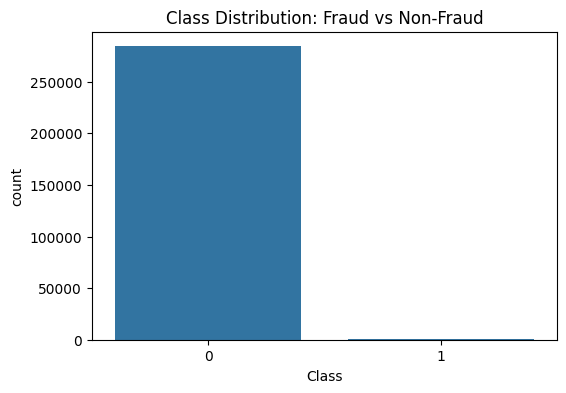

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Class')
plt.title('Class Distribution: Fraud vs Non-Fraud')
plt.show()

In [8]:
df.groupby('Class')['Amount'].describe()
df.groupby('Class')['Time'].describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,284315.0,94838.202258,47484.015786,0.0,54230.0,84711.0,139333.0,172792.0
1,492.0,80746.806911,47835.365138,406.0,41241.5,75568.5,128483.0,170348.0


In [9]:
#Checking if there are missing values in the dataset.

df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

##### We can see above that there are no missing values presesnt in the entire dataset.

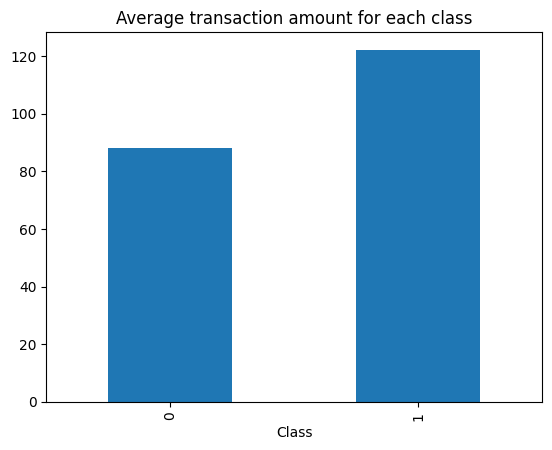

In [10]:
df.groupby('Class')['Amount'].mean().plot(kind='bar', title='Average transaction amount for each class')
plt.show()

##### From the above plot we can observe that the average transaction value is higher in case of a fraud transaction.

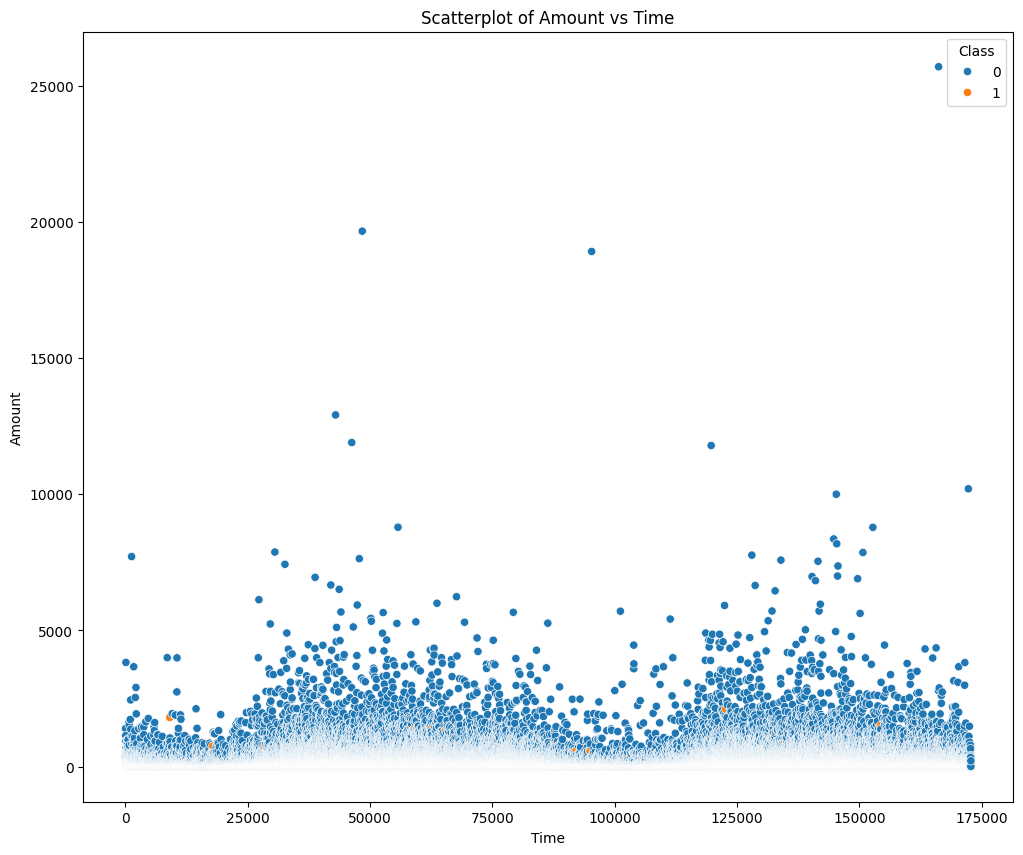

In [11]:
plt.figure(figsize=(12,10))
sns.scatterplot(data=df, x='Time', y='Amount', hue='Class')
plt.title('Scatterplot of Amount vs Time')
plt.show()

##### The obove scatter plot shows the spread of transaction over time-elapsed since first transaction. Fraud transactions, represented with orange dots, are very few and far between, which makes sense since the fraud cases are very few in the data set.

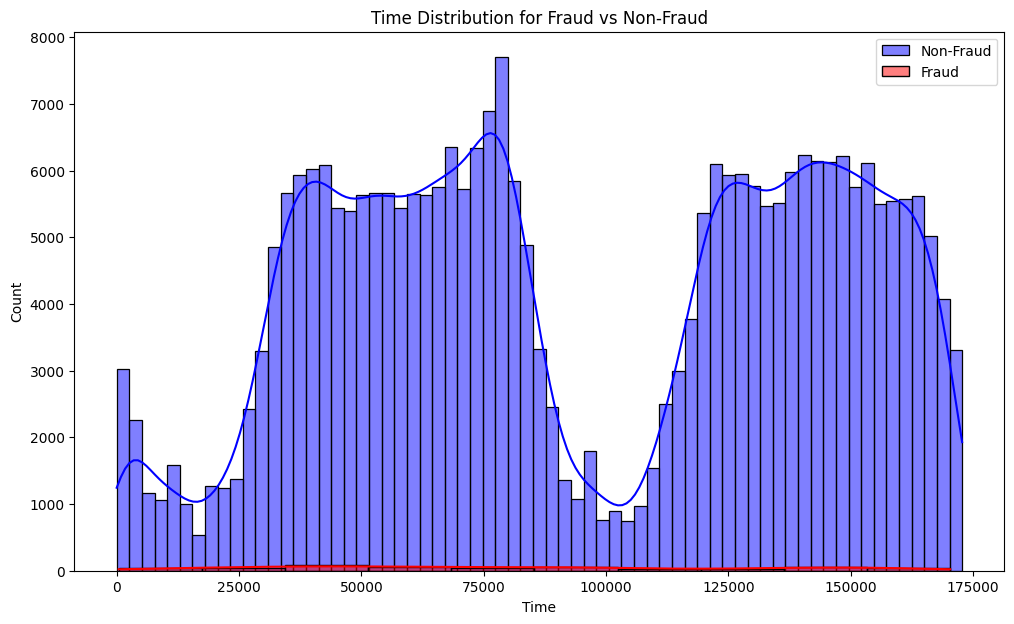

In [12]:
plt.figure(figsize=(12, 7))
sns.histplot(data=df[df['Class'] == 0], x='Time', color='blue', label='Non-Fraud', kde=True)
sns.histplot(data=df[df['Class'] == 1], x='Time', color='red', label='Fraud', kde=True)
plt.legend()
plt.title('Time Distribution for Fraud vs Non-Fraud')
plt.show()

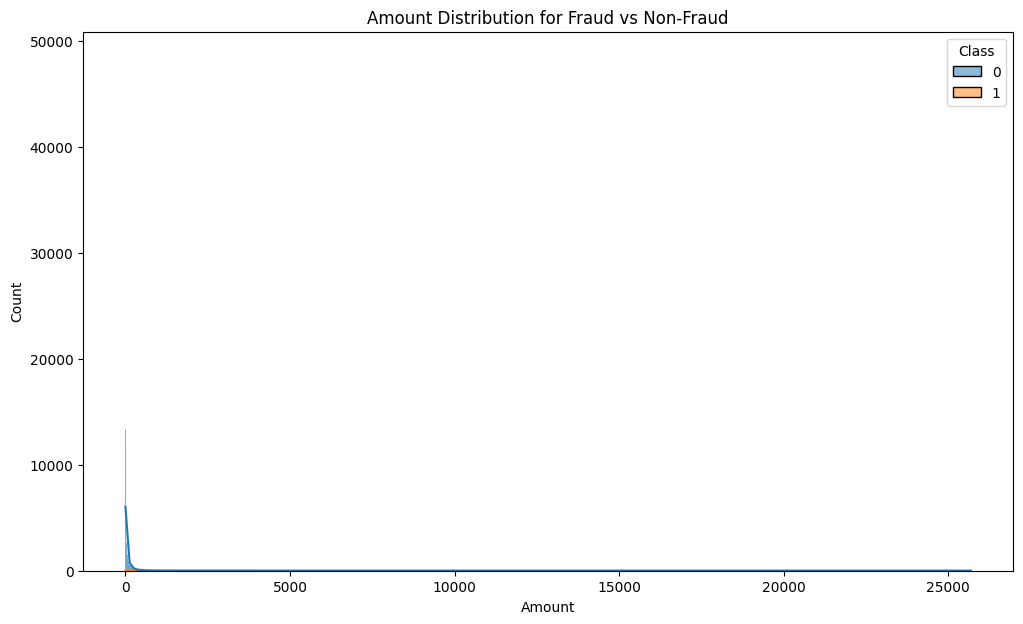

In [13]:
plt.figure(figsize=(12, 7))
sns.histplot(data=df, x='Amount', hue='Class', kde=True)
plt.title('Amount Distribution for Fraud vs Non-Fraud')
plt.show()

### Correlation between numerical features.

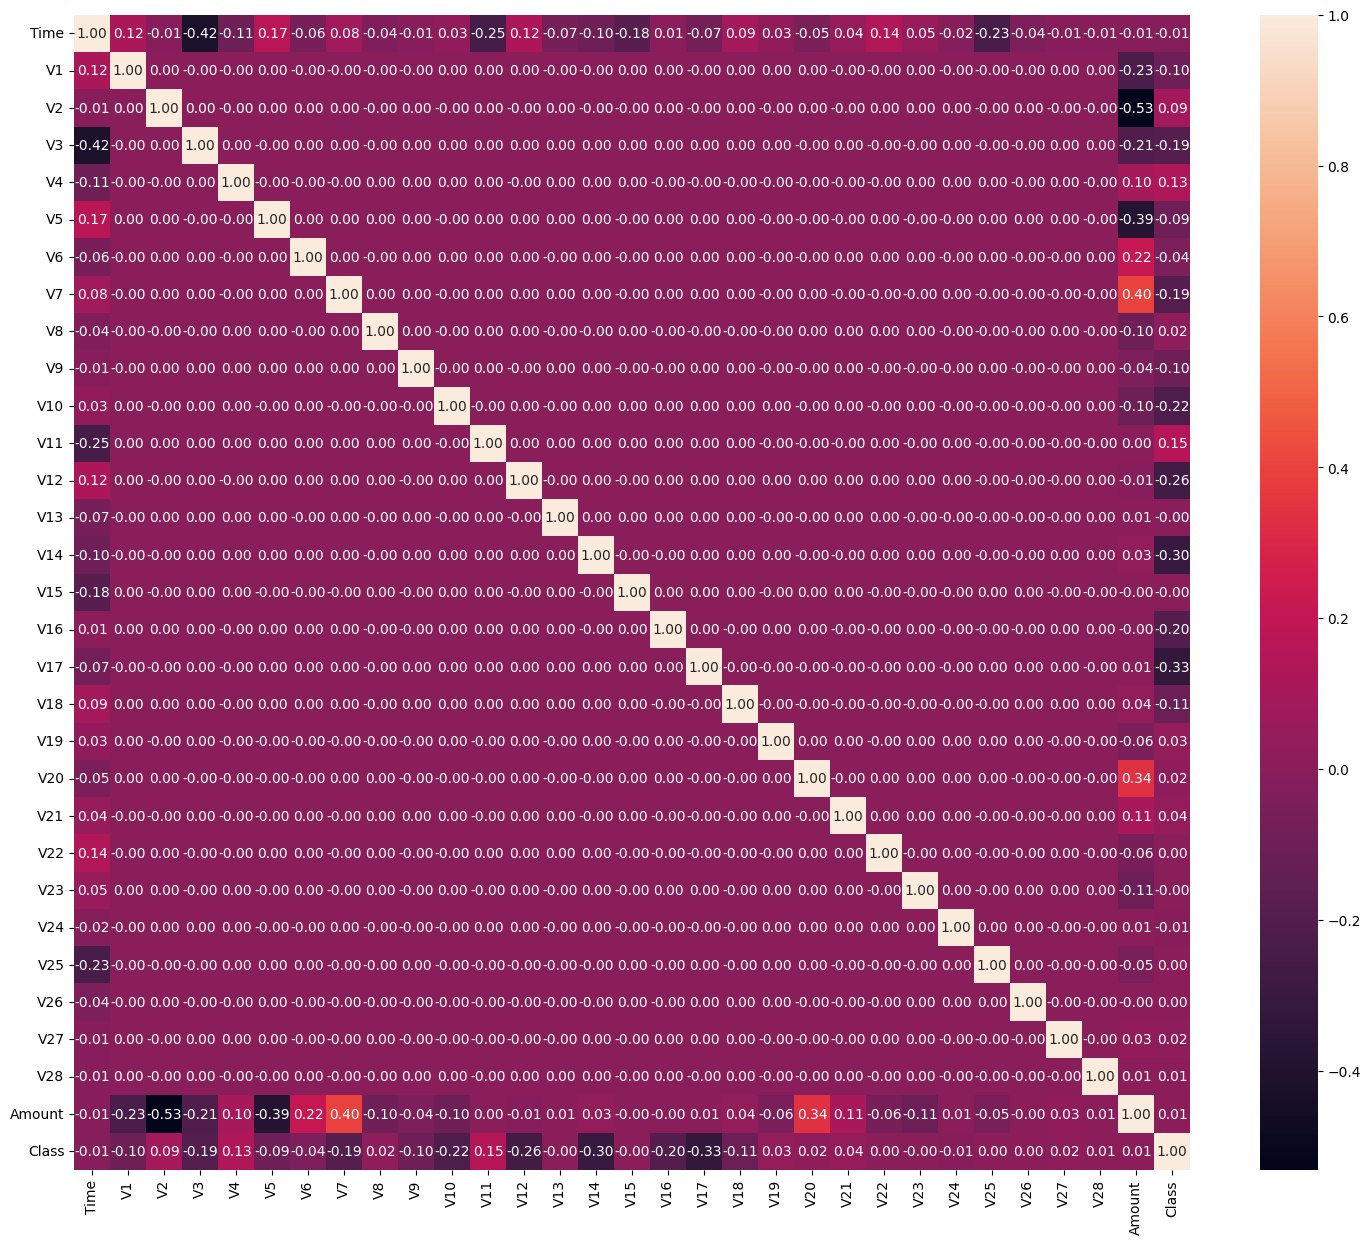

In [14]:

plt.figure(figsize=(18, 15))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()


##### From the above correlation heatmap we can clearly conclude that no two features are either positively or negatively highly correlated. That also implies that each feature in the data set carries unique information that would help the model to learn patterns more effectively.

### Investigating and dealing with outliers in the data.

 ##### Lets now see the distribution of each numerical feature and detect outliers using boxplots.

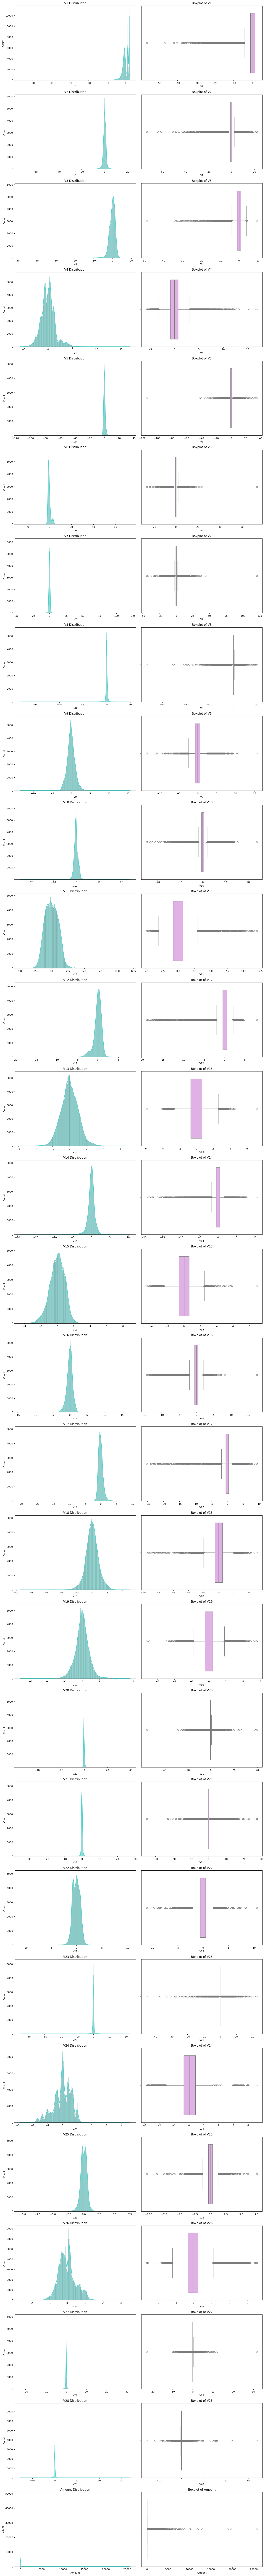

In [15]:
num_cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 
            'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

fig, ax = plt.subplots(nrows=29, ncols=2, figsize=(15, 145))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(num_cols):
    sns.histplot(df[col], ax=ax[i, 0], color='mediumturquoise', kde=True)
    sns.boxplot(data=df, x=df[col], ax=ax[i, 1], color='#E6A9EC')
    ax[i, 0].set_title(f"{col} Distribution")
    ax[i, 1].set_title(f"Boxplot of {col}")

plt.tight_layout()

##### From the above plots we can observe that all the features except 'Time' have outliers present in them.

##### Creating some helper functions to analyse the outliers

In [16]:
def lower_upper_whisker_value(data):
    """
    This function calculates the lower and upper whisker values for outlier detection using the IQR method.

    Parameters: data (pd.Series): The data for which to calculate the whisker values.
    Returns: tuple: A tuple containing the lower and upper whisker values.

    """

    Q1 = np.quantile(data, 0.25)
    Q3 = np.quantile(data, 0.75)

    IQR = Q3-Q1

    lower_whisker = Q1 - (1.5 * IQR)
    upper_whisker = Q3 + (1.5 * IQR)

    return lower_whisker, upper_whisker


def display_outlier_percentage(data):
    """
    This function calculates the percentage of outliers in each numeric column of the DataFrame.

    Parameters: data (pd.DataFrame): The DataFrame containing the data.
    Returns: pd.DataFrame: A DataFrame containing the percentage of outliers for each numeric column.
    
    """

    outlier_list = []

    for column in data.columns:

        if data[column].dtype == 'float64':

            lower_whisker, upper_whisker = lower_upper_whisker_value(data[column])
            data_filtered = data[(data[column] < lower_whisker) | (data[column] > upper_whisker)]
            outlier_percentage = (len(data_filtered) / len(data))*100

            outlier_list.append({'Feature': column, 'Outlier Percentage': outlier_percentage})

    final_df = pd.DataFrame(outlier_list)

    return final_df

In [17]:
# Lets print and visualize the outlier percentage for each numeric column

outliers = display_outlier_percentage(df)
outliers

,Feature,Outlier Percentage
0,Time,0.000000
1,V1,2.479574
2,V2,4.749181
3,V3,1.180800
4,V4,3.914230
5,V5,4.316959
6,V6,8.063355
7,V7,3.141777
8,V8,8.473809
9,V9,2.908285


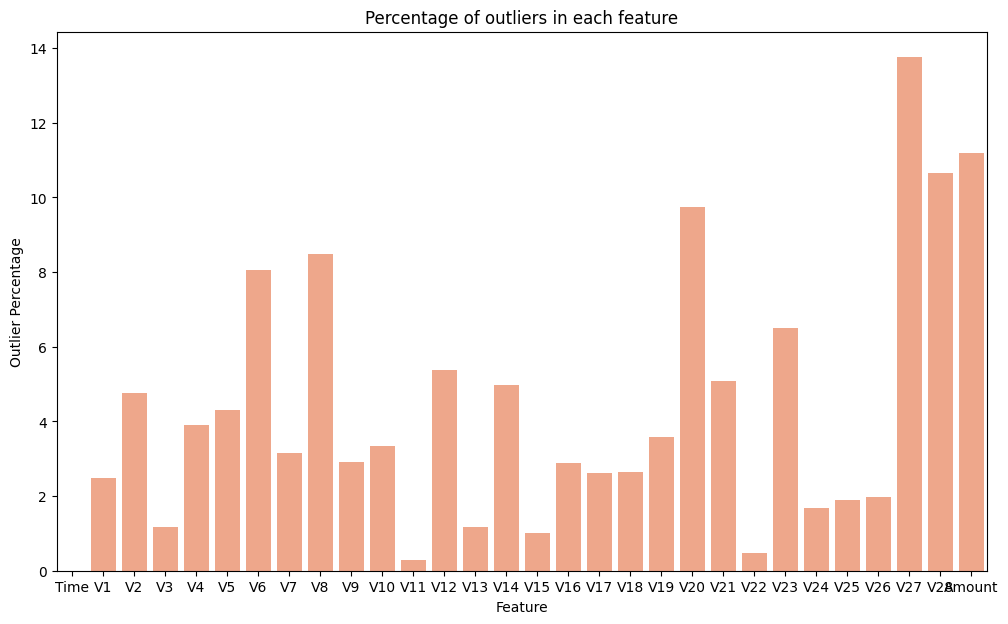

In [18]:
outliers = display_outlier_percentage(df)

plt.figure(figsize=(12,7))
sns.barplot(data=outliers, x='Feature', y='Outlier Percentage', color='#FFA07A')
plt.title('Percentage of outliers in each feature')
plt.show()

##### Features 'V27', 'V28', and 'Amount' have significantly high number of outliers (>10%), lets now see how fraud cases are present within these outliers. This will help us decide what would make sense, removing or capping the outliers.

In [19]:
# Calculating the 95th percentile for Amount
upper_limit = df['V27'].quantile(0.95)
lower_limit = df['V27'].quantile(0.05)

# Filtering the outliers (Above 95th percentile)
outliers = df[df['V27'] > upper_limit]

# Checking how many fraud transactions are in the outliers
fraud_in_outliers = outliers[outliers['Class'] == 1]

print(f'Outliers in V27: {len(outliers)}')
print(f'Fraudulent Transactions in Outliers: {len(fraud_in_outliers)}')


Outliers in V27: 14241
Fraudulent Transactions in Outliers: 250


In [20]:
upper_limit = df['V28'].quantile(0.95)
lower_limit = df['V28'].quantile(0.05)

outliers = df[df['V28'] > upper_limit]

fraud_in_outliers = outliers[outliers['Class'] == 1]

print(f'Outliers in V28: {len(outliers)}')
print(f'Fraudulent Transactions in Outliers: {len(fraud_in_outliers)}')

Outliers in V28: 14241
Fraudulent Transactions in Outliers: 186


In [21]:
upper_limit = df['Amount'].quantile(0.95)
lower_limit = df['Amount'].quantile(0.05)

outliers = df[df['Amount'] > upper_limit]

fraud_in_outliers = outliers[outliers['Class'] == 1]

print(f'Outliers in Amount: {len(outliers)}')
print(f'Fraudulent Transactions in Outliers: {len(fraud_in_outliers)}')

Outliers in Amount: 14232
Fraudulent Transactions in Outliers: 43


##### We can observe above that the outliers in these features are associated with a lot of fraudulent transactions, so removing them would lead to a loss of very crucial data and given the fact that we are already running low on positive class, it does not make sense to remove them.

##### Lets cap these features with 95th percentile values

In [22]:
# Defining the 95th percentile as the upper limit for capping
upper_limit_amount = df['Amount'].quantile(0.95)
upper_limit_V27 = df['V27'].quantile(0.95)
upper_limit_V28 = df['V28'].quantile(0.95)

# Capping
df['Amount'] = df['Amount'].clip(upper=upper_limit_amount)
df['V27'] = df['V27'].clip(upper=upper_limit_V27)
df['V28'] = df['V28'].clip(upper=upper_limit_V28)

print(f"Amount capped at: {upper_limit_amount}")
print(f"V27 capped at: {upper_limit_V27}")
print(f"V28 capped at: {upper_limit_V28}")

Amount capped at: 365.0
V27 capped at: 0.38774615695675985
V28 capped at: 0.2560897064846804


### Preprocessing - Oversampling and Scaling

##### First lets split the data into train and test sets.

In [23]:
X = df.drop(columns=['Class'])
y = df['Class']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train) # For Neural Network validation

In [25]:
X_train_val.shape, y_train_val.shape, X_test_val.shape, y_test_val.shape

((170883, 30), (170883,), (56962, 30), (56962,))

In [26]:
smt = SMOTE()
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)
X_val_res, y_val_res = smt.fit_resample(X_train_val, y_train_val)

In [27]:
X_train_res.shape, y_train_res.shape, X_val_res.shape, y_val_res.shape

((454902, 30), (454902,), (341176, 30), (341176,))

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)
X_train_val_scaled = scaler.transform(X_val_res)
X_test_val_scaled = scaler.transform(X_test_val)

In [29]:
X_train_scaled.shape, y_train_res.shape

((454902, 30), (454902,))

In [30]:
X_test_val_scaled.shape, y_test_val.shape

((56962, 30), (56962,))

### Logistic Regression Model

In [31]:
def display_metrics(y_true, y_pred, model_name, model):
    """
    This function displays the accuracy, confusion matrix, classification report, ROC AUC score, and PR AUC score for a given model.

    Parameters:
    y_true (pd.Series): True labels.
    y_pred (pd.Series): Predicted labels.
    model_name (str): Name of the model.
    model (sklearn estimator): Trained model to use for probability prediction.
    """
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy of {model_name}: {accuracy:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    # Classification Report
    print(classification_report(y_true, y_pred))
    
    # ROC AUC Score
    roc_auc = roc_auc_score(y_true, model.predict_proba(X_test_scaled)[:, 1])
    print(f"ROC AUC Score for {model_name}: {roc_auc:.4f}")
    
    # PR AUC Score
    pr_auc = average_precision_score(y_true, model.predict_proba(X_test_scaled)[:, 1])
    print(f"PR AUC Score for {model_name}: {pr_auc:.4f}")

/Users/farazahmed/Documents/Credit-Card-Fraud-Detection/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/farazahmed/Documents/Credit-Card-Fraud-Detection/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/farazahmed/Documents/Credit-Card-Fraud-Detection/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/farazahmed/Documents/Credit-Card-Fraud-Detection/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/farazahmed/Documents/Credit-Card-Fraud-Detection/.venv/lib/python3.9/site-packages/sklearn/li

Best parameters: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy of Best Logistic Regression Model: 0.9904


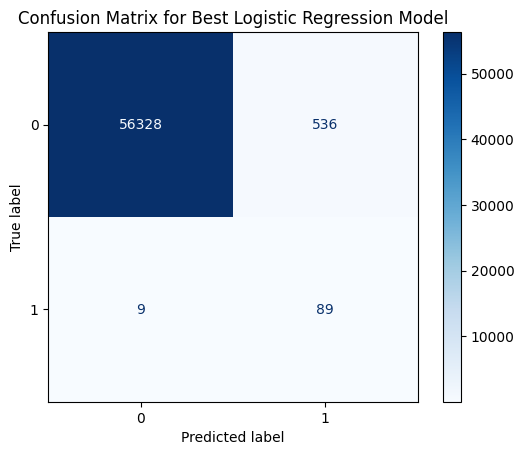

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.14      0.91      0.25        98

    accuracy                           0.99     56962
   macro avg       0.57      0.95      0.62     56962
weighted avg       1.00      0.99      0.99     56962

ROC AUC Score for Best Logistic Regression Model: 0.9751
PR AUC Score for Best Logistic Regression Model: 0.7326


In [32]:
# Hyperparameter tuning using GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2', 'none'],
    'solver': ['lbfgs', 'saga']
}

scorer_pr_auc = make_scorer(average_precision_score, pos_label=1)

grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    cv=5,
    scoring=scorer_pr_auc,
    refit=True,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train_res)
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
predictions_best_LR = best_model.predict(X_test_scaled)
display_metrics(y_test, predictions_best_LR, "Best Logistic Regression Model", best_model)

##### We can see above that we are getting an accuracy of 99%, this is happening because the model is classifying majority of the points as "Not fraud" and the dataset contains mostly "Not fraud" cases. However, if we focus on precision for the positive class, it is only 15%, which is very poor. It implies that out of every 100 predicted "Fraud" cases only 14 are actually Fraud, and the rest 85 are being misclassified.

##### Recall for the model is pretty good (87%), it means that the model is able correctly classify 91 fraud cases out of every 100 actual fraud data points. However, in doing that our precision is suffering which is leading to a trade off between precision and recall.

##### In credit card fraud detection it is imperative that both the metrics - Precision & Recall are properly balanced. This is because a true fraud transaction if not caught is harmful to both the customer and the organisation, not just in monetery terms but also in terms of reputation and in a case where a "Not Fraud" transaction is flagged as Fraud, it is simply annoying to the customer and leads to a bad user experience which is equally harmful as it may impact usage and contribute to churn.

##### Hence in this business case, we will use F-1 Score and PR AUC score to give us a better measure of the model performance. A good balance between Precision and Recall is what we are looking for.

##### Even with hyperparameter tuning we can see that precision hasn't imporoved at all and PR AUC score is very poor. This suggests the Logistic Regression model might not be a good fit here.

### XGBoost Model

Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Accuracy of Best XGBoost Model: 0.9995


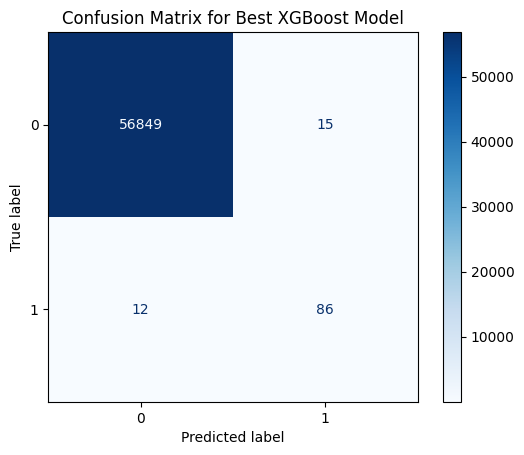

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.88      0.86        98

    accuracy                           1.00     56962
   macro avg       0.93      0.94      0.93     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score for Best XGBoost Model: 0.9860
PR AUC Score for Best XGBoost Model: 0.8771


In [33]:
#XGBoost model with hyperparameter tuning

param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

scorer_pr_auc_xgb = make_scorer(average_precision_score, pos_label=1)

grid_search_xgb = GridSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid_xgb,
    cv=5,
    scoring=scorer_pr_auc_xgb,
    refit=True,
    n_jobs=-1
)


grid_search_xgb.fit(X_train_scaled, y_train_res)
best_model_xgb = grid_search_xgb.best_estimator_
print(f"Best parameters for XGBoost: {grid_search_xgb.best_params_}")
predictions_best_xgb = best_model_xgb.predict(X_test_scaled)
display_metrics(y_test, predictions_best_xgb, "Best XGBoost Model", best_model_xgb)

##### The XGBoost model as we can see above performs quite better than the logistic regression model. This would suggest that tree-based boosting models are working better on this dataset. Similar models like GBDT and LightGBM would also perform the same.

##### PR AUC score is 88% which means that the model is successful in identifying the positive ("Fraud") cases efficiently. On top of that we also have high precision and recall scores indicating that the earlier trade off that we were facing with Logistic Regression has been handeled.

##### Further hyperparameter tuning might improve the performance even further.

### Neural Network Model

In [34]:
# Let build a neural network model using tensorflow and keras for classification.

model_NN = Sequential([
    Dense(256, input_shape=(X_train_scaled.shape[1],), activation='relu'),

    Dense(128),
    ReLU(),

    Dense(64),
    ReLU(),

    Dense(32),
    ReLU(),

    Dense(16),
    ReLU(),

    Dense(1, activation='sigmoid')
])

In [35]:
model_NN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,713 (202.00 KB)

 Trainable params: 51,713 (202.00 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model_NN.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['precision', 'recall', 'accuracy']
)

In [37]:
model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

history = model_NN.fit(
    X_train_scaled,
    y_train_res,
    epochs=50,
    batch_size=256,
    validation_data=(X_test_val_scaled, y_test_val),
    callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/50
1735/1777 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.9834 - loss: 0.0518 - precision: 0.9899 - recall: 0.9766

1777/1777 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9837 - loss: 0.0510 - precision: 0.9900 - recall: 0.9770 - val_accuracy: 0.9992 - val_loss: 0.0043 - val_precision: 0.7029 - val_recall: 0.9798
Epoch 2/50
1751/1777 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.9986 - loss: 0.0050 - precision: 0.9982 - recall: 0.9990

1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 916us/step - accuracy: 0.9986 - loss: 0.0050 - precision: 0.9982 - recall: 0.9990 - val_accuracy: 0.9995 - val_loss: 0.0025 - val_precision: 0.7823 - val_recall: 0.9798
Epoch 3/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 996us/step - accuracy: 0.9991 - loss: 0.0034 - precision: 0.9988 - recall: 0.9995 - val_accuracy: 0.9990 - val_loss: 0.0041 - val_precision: 0.6266 - val_recall: 1.0000
Epoch 4/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 997us/step - accuracy: 0.9994 - loss: 0.0024 - precision: 0.9991 - recall: 0.9996 - val_accuracy: 0.9993 - val_loss: 0.0030 - val_precision: 0.7080 - val_recall: 0.9798
Epoch 5/50
1775/1777 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.9994 - loss: 0.0022 - precision: 0.9992 - recall: 0.9996

1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9994 - loss: 0.0022 - precision: 0.9992 - recall: 0.9996 - val_accuracy: 0.9997 - val_loss: 8.9819e-04 - val_precision: 0.8661 - val_recall: 0.9798
Epoch 6/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9996 - loss: 0.0017 - precision: 0.9994 - recall: 0.9997 - val_accuracy: 0.9995 - val_loss: 0.0015 - val_precision: 0.7795 - val_recall: 1.0000
Epoch 7/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9995 - loss: 0.0016 - precision: 0.9994 - recall: 0.9997 - val_accuracy: 0.9997 - val_loss: 9.5472e-04 - val_precision: 0.8390 - val_recall: 1.0000
Epoch 8/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9996 - loss: 0.0013 - precision: 0.9995 - recall: 0.9997 - val_accuracy: 0.9996 - val_loss: 0.0016 - val_precision: 0.8182 - val_recall: 1.0000
Epoch 9/50
1730/1777 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.9995 - loss: 0.0016 - precision: 0.9995 - recall: 0.9996

1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9995 - loss: 0.0016 - precision: 0.9995 - recall: 0.9996 - val_accuracy: 0.9998 - val_loss: 8.1818e-04 - val_precision: 0.9000 - val_recall: 1.0000
Epoch 10/50
1733/1777 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.9997 - loss: 9.3036e-04 - precision: 0.9997 - recall: 0.9998

1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9997 - loss: 9.3218e-04 - precision: 0.9997 - recall: 0.9998 - val_accuracy: 0.9999 - val_loss: 3.8393e-04 - val_precision: 0.9429 - val_recall: 1.0000
Epoch 11/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9998 - loss: 8.0390e-04 - precision: 0.9998 - recall: 0.9998 - val_accuracy: 0.9997 - val_loss: 9.3554e-04 - val_precision: 0.8534 - val_recall: 1.0000
Epoch 12/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 960us/step - accuracy: 0.9997 - loss: 9.5672e-04 - precision: 0.9997 - recall: 0.9998 - val_accuracy: 0.9998 - val_loss: 7.9946e-04 - val_precision: 0.8761 - val_recall: 1.0000
Epoch 13/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9998 - loss: 6.4021e-04 - precision: 0.9997 - recall: 0.9999 - val_accuracy: 0.9999 - val_loss: 4.0968e-04 - val_precision: 0.9519 - val_recall: 1.0000
Epoch 14/50
1735/1777 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9998 - loss: 6.4753e-04 - precision: 0.9998 - recall: 0.9

1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9998 - loss: 6.5239e-04 - precision: 0.9998 - recall: 0.9999 - val_accuracy: 0.9999 - val_loss: 3.5077e-04 - val_precision: 0.9340 - val_recall: 1.0000
Epoch 15/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9998 - loss: 6.9045e-04 - precision: 0.9998 - recall: 0.9999 - val_accuracy: 0.9999 - val_loss: 3.8233e-04 - val_precision: 0.9340 - val_recall: 1.0000
Epoch 16/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9998 - loss: 6.7816e-04 - precision: 0.9998 - recall: 0.9998 - val_accuracy: 0.9998 - val_loss: 5.3904e-04 - val_precision: 0.9083 - val_recall: 1.0000
Epoch 17/50
1755/1777 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9998 - loss: 5.1004e-04 - precision: 0.9998 - recall: 0.9999

1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9998 - loss: 5.1056e-04 - precision: 0.9998 - recall: 0.9999 - val_accuracy: 0.9999 - val_loss: 2.3556e-04 - val_precision: 0.9612 - val_recall: 1.0000
Epoch 18/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9997 - loss: 9.4562e-04 - precision: 0.9997 - recall: 0.9997 - val_accuracy: 0.9999 - val_loss: 2.7930e-04 - val_precision: 0.9429 - val_recall: 1.0000
Epoch 19/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9999 - loss: 3.2479e-04 - precision: 0.9999 - recall: 0.9999 - val_accuracy: 0.9999 - val_loss: 4.6590e-04 - val_precision: 0.9429 - val_recall: 1.0000
Epoch 20/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9999 - loss: 5.5150e-04 - precision: 0.9998 - recall: 0.9999 - val_accuracy: 0.9996 - val_loss: 0.0069 - val_precision: 0.8182 - val_recall: 1.0000
Epoch 21/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9998 - loss: 7.5733e-04 - precision: 0.9998 - recall: 0.9999 - 

1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9999 - loss: 4.2488e-04 - precision: 0.9999 - recall: 0.9999 - val_accuracy: 0.9999 - val_loss: 1.8296e-04 - val_precision: 0.9519 - val_recall: 1.0000
Epoch 26/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9999 - loss: 5.0435e-04 - precision: 0.9998 - recall: 0.9999 - val_accuracy: 0.9999 - val_loss: 3.1190e-04 - val_precision: 0.9706 - val_recall: 1.0000
Epoch 27/50
1776/1777 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.9999 - loss: 3.5038e-04 - precision: 0.9999 - recall: 1.0000

1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9999 - loss: 3.5068e-04 - precision: 0.9999 - recall: 1.0000 - val_accuracy: 0.9999 - val_loss: 1.2170e-04 - val_precision: 0.9706 - val_recall: 1.0000
Epoch 28/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 985us/step - accuracy: 0.9999 - loss: 2.9188e-04 - precision: 0.9999 - recall: 0.9999 - val_accuracy: 0.9999 - val_loss: 2.5294e-04 - val_precision: 0.9612 - val_recall: 1.0000
Epoch 29/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 931us/step - accuracy: 0.9999 - loss: 4.1458e-04 - precision: 0.9998 - recall: 0.9999 - val_accuracy: 0.9998 - val_loss: 6.5968e-04 - val_precision: 0.9000 - val_recall: 1.0000
Epoch 30/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9999 - loss: 3.9680e-04 - precision: 0.9998 - recall: 0.9999 - val_accuracy: 0.9999 - val_loss: 1.7414e-04 - val_precision: 0.9612 - val_recall: 1.0000
Epoch 31/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9999 - loss: 3.1209e-04 - precision: 0.9999 - recall: 0

1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 982us/step - accuracy: 0.9999 - loss: 4.1815e-04 - precision: 0.9998 - recall: 0.9999 - val_accuracy: 1.0000 - val_loss: 7.0020e-05 - val_precision: 0.9900 - val_recall: 1.0000
Epoch 33/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9999 - loss: 4.4641e-04 - precision: 0.9999 - recall: 0.9999 - val_accuracy: 0.9999 - val_loss: 3.6784e-04 - val_precision: 0.9252 - val_recall: 1.0000
Epoch 34/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 988us/step - accuracy: 0.9999 - loss: 3.8327e-04 - precision: 0.9999 - recall: 0.9999 - val_accuracy: 0.9999 - val_loss: 9.5836e-05 - val_precision: 0.9612 - val_recall: 1.0000
Epoch 35/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 979us/step - accuracy: 0.9999 - loss: 2.0693e-04 - precision: 0.9999 - recall: 0.9999 - val_accuracy: 1.0000 - val_loss: 1.0160e-04 - val_precision: 0.9802 - val_recall: 1.0000
Epoch 36/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9999 - loss: 4.9336e-04 - precision: 0.9999 - recall:

1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9999 - loss: 4.9625e-04 - precision: 0.9998 - recall: 0.9999 - val_accuracy: 1.0000 - val_loss: 5.8459e-05 - val_precision: 0.9900 - val_recall: 1.0000
Epoch 43/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 1.0000 - loss: 1.0330e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9999 - val_loss: 4.8338e-04 - val_precision: 0.9429 - val_recall: 1.0000
Epoch 44/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9999 - loss: 3.5135e-04 - precision: 0.9999 - recall: 0.9999 - val_accuracy: 0.9998 - val_loss: 6.3440e-04 - val_precision: 0.9083 - val_recall: 1.0000
Epoch 45/50
1747/1777 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - accuracy: 0.9998 - loss: 7.8802e-04 - precision: 0.9998 - recall: 0.9999

1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9998 - loss: 7.8644e-04 - precision: 0.9998 - recall: 0.9999 - val_accuracy: 1.0000 - val_loss: 4.9654e-05 - val_precision: 0.9900 - val_recall: 1.0000
Epoch 46/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 947us/step - accuracy: 1.0000 - loss: 6.9863e-05 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9999 - val_loss: 1.2913e-04 - val_precision: 0.9706 - val_recall: 1.0000
Epoch 47/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 985us/step - accuracy: 0.9999 - loss: 3.3377e-04 - precision: 0.9999 - recall: 0.9999 - val_accuracy: 0.9999 - val_loss: 1.4158e-04 - val_precision: 0.9706 - val_recall: 1.0000
Epoch 48/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9999 - loss: 5.3306e-04 - precision: 0.9999 - recall: 0.9999 - val_accuracy: 0.9992 - val_loss: 0.0203 - val_precision: 0.6735 - val_recall: 1.0000
Epoch 49/50
1755/1777 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9998 - loss: 7.9110e-04 - precision: 0.9998 - recall: 0.999

1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9998 - loss: 7.8668e-04 - precision: 0.9998 - recall: 0.9999 - val_accuracy: 1.0000 - val_loss: 2.5465e-05 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 50/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 1.0000 - loss: 5.9054e-05 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9999 - val_loss: 4.3047e-04 - val_precision: 0.9429 - val_recall: 1.0000


In [38]:
epochs = history.epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

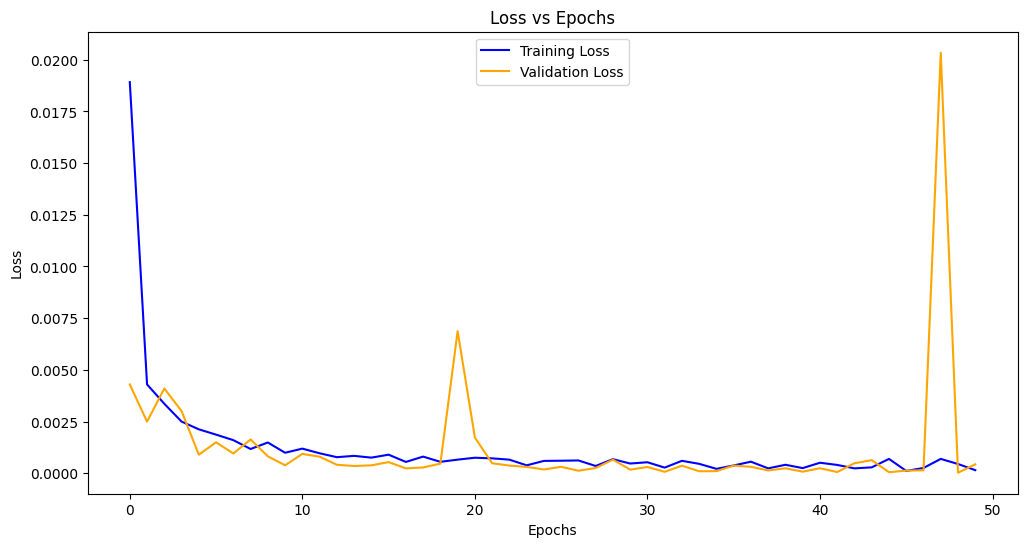

In [39]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=epochs, y=loss, label='Training Loss', color='blue')
sns.lineplot(x=epochs, y=val_loss, label='Validation Loss', color='orange')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
best_model = tf.keras.models.load_model('best_model.h5')

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 322us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.81      0.85        98

    accuracy                           1.00     56962
   macro avg       0.95      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



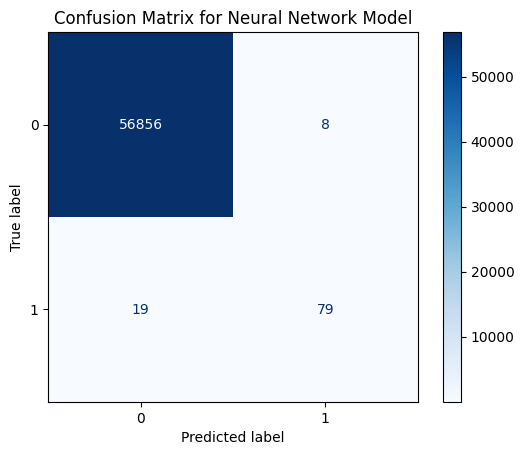

In [41]:
predictions = best_model.predict(X_test_scaled)

predictions_class = (predictions > 0.5).astype(int)

cm = confusion_matrix(y_test, predictions_class)

print(classification_report(y_test, predictions_class))
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
plt.title('Confusion Matrix for Neural Network Model')
plt.show()

##### We can see above that the Neural Network model performs almost the same as the XGBoost model.

Performance Summary for Logistic Regression:
Accuracy: 0.9904
ROC AUC Score: 0.9494
PR AUC Score: 0.1295

Performance Summary for XGBoost:
Accuracy: 0.9995
ROC AUC Score: 0.9386
PR AUC Score: 0.7474

Performance Summary for Neural Network:
Accuracy: 0.9995
ROC AUC Score: 0.9030
PR AUC Score: 0.7323

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step


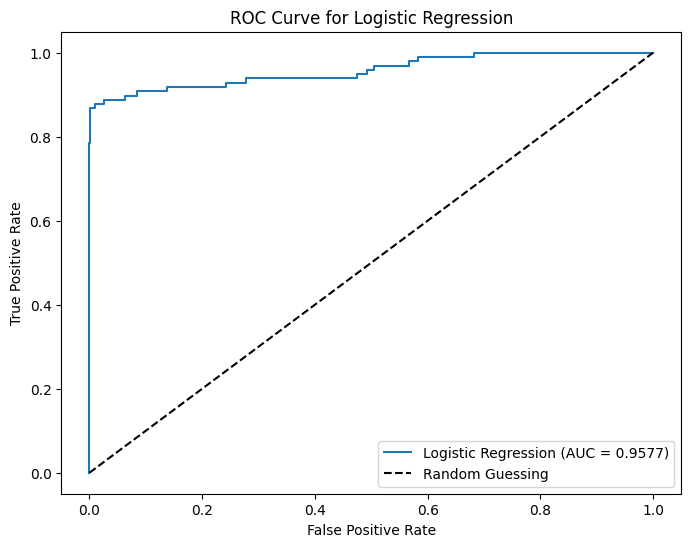

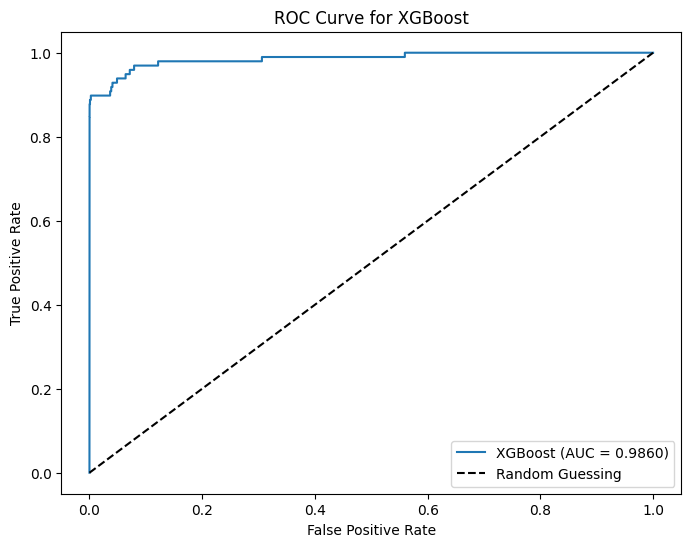

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


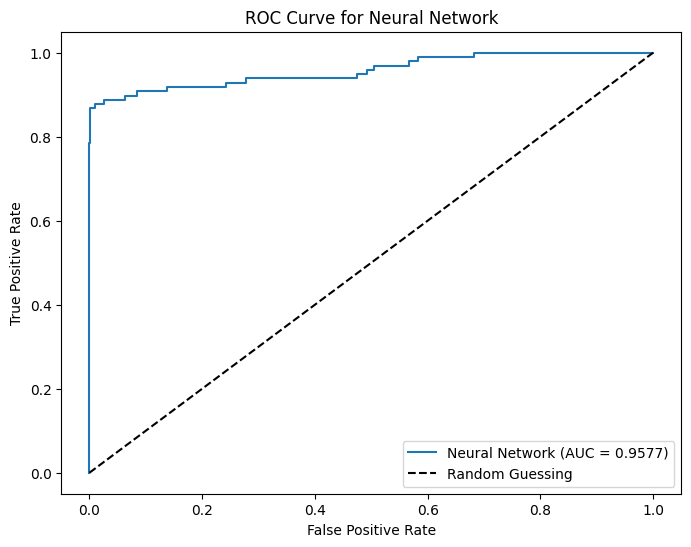

In [45]:
# Performance summary for all models

def performance_summary(y_true, y_pred, model_name):
    """
    This function summarizes the performance of a model by displaying accuracy, ROC AUC score, and PR AUC score.

    Parameters:
    y_true (pd.Series): True labels.
    y_pred (pd.Series): Predicted labels.
    model_name (str): Name of the model.
    """
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_pred)

    print(f"Performance Summary for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"PR AUC Score: {pr_auc:.4f}\n")

performance_summary(y_test, predictions_best_LR, "Logistic Regression")

performance_summary(y_test, predictions_best_xgb, "XGBoost")

performance_summary(y_test, predictions_class, "Neural Network")

def plot_roc_curve(y_true, y_pred_proba, model_name):
    """
    This function plots the ROC curve for a given model.

    Parameters:
    y_true (pd.Series): True labels.
    y_pred_proba (np.array): Predicted probabilities.
    model_name (str): Name of the model.
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend()
    plt.show()


plot_roc_curve(y_test, best_model.predict(X_test_scaled), "Logistic Regression")

plot_roc_curve(y_test, best_model_xgb.predict_proba(X_test_scaled)[:, 1], "XGBoost")

plot_roc_curve(y_test, best_model.predict(X_test_scaled), "Neural Network")